In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten,Input, concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
import tensorflow.keras.utils as utils

from datetime import datetime
# import cv2
import glob
import zipfile
import os
import shutil

from tensorflow.keras.applications import Xception, ResNet50
from tensorflow.keras.applications import InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# 인터넷 서비스 Churn 예측 모델

## 인터넷 서비스 파일 불러오기

In [3]:
service = pd.read_csv("internet_service_churn.csv")
service.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


## 데이터 전처리

#### 결측치, 이상치 확인

In [4]:
service.isna().sum()
# 총 7만여건 중에 남은계약 21572건, 
# 평균 다운로드랑 엽로드 평균이 381건이 결측치로 확인된다.

id                                 0
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64

In [54]:
len(service)

72274

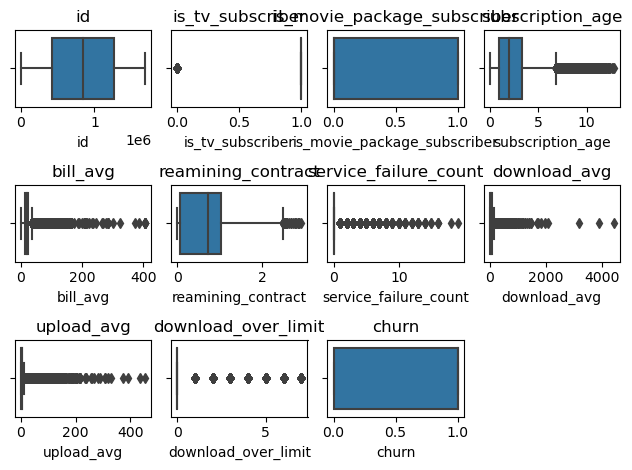

In [43]:
for i in range(len(service.columns)):
    plt.subplot(3, 4, i+1)
    sns.boxplot(service[service.columns[i]])
    plt.title(service.columns[i])
plt.tight_layout()

#### 결측치 처리하기(mean)

In [5]:
for i in range(len(service.columns)):
    service[service.columns[i]].fillna(service[service.columns[i]].mean(), inplace=True)

In [6]:
print(service.isna().sum())
## 컬럼 개수 확인하기
print(len(service.columns)) 

id                             0
is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
reamining_contract             0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
churn                          0
dtype: int64
11


In [14]:
service.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           72274 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 72274 non-null  float64
 8   upload_avg                   72274 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


<AxesSubplot:xlabel='churn', ylabel='download_avg'>

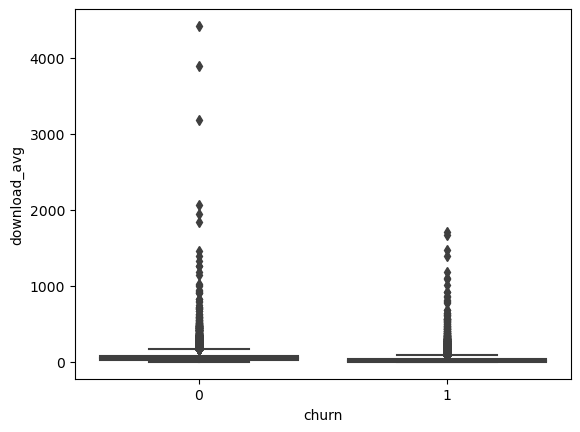

In [27]:
%matplotlib inline
sns.boxplot(x="churn", y="download_avg", data=service)

<AxesSubplot:xlabel='churn', ylabel='upload_avg'>

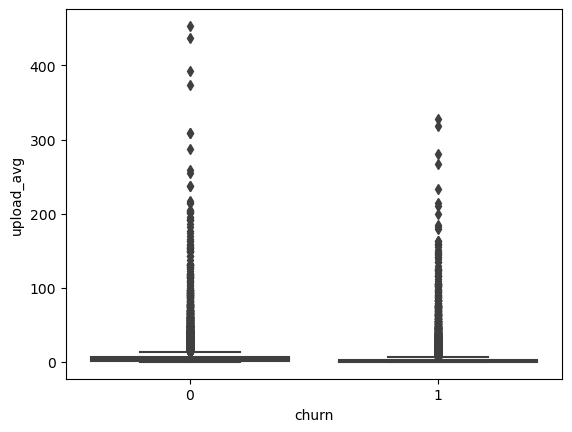

In [56]:
%matplotlib inline
sns.boxplot(x="churn", y="upload_avg", data=service)

In [44]:
service.describe()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
count,7.227400e+04,72274.000000,72274.000000,72274.000000,72274.000000,72274.000000,72274.000000,72274.000000,72274.000000,72274.000000,72274.000000
mean,8.463182e+05,0.815259,0.334629,2.450051,18.942483,0.716039,0.274234,43.689911,4.192076,0.207613,0.554141
std,4.891022e+05,0.388090,0.471864,2.034990,13.215386,0.583871,0.816621,63.238614,9.792981,0.997123,0.497064
min,1.500000e+01,0.000000,0.000000,-0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.222165e+05,1.000000,0.000000,0.930000,13.000000,0.070000,0.000000,6.800000,0.500000,0.000000,0.000000
50%,8.477840e+05,1.000000,0.000000,1.980000,19.000000,0.716039,0.000000,28.100000,2.100000,0.000000,1.000000
75%,1.269562e+06,1.000000,1.000000,3.300000,22.000000,1.040000,0.000000,60.200000,4.800000,0.000000,1.000000
max,1.689744e+06,1.000000,1.000000,12.800000,406.000000,2.920000,19.000000,4415.200000,453.300000,7.000000,1.000000


## Train, Test Data 분류

In [7]:
X = service[service.columns[:-1]]
y = service["churn"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 정규화

In [9]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

### 모델 학습후 결과 확인하기

In [11]:
model = Sequential()
model.add(Flatten(input_shape=(10,)))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(4, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
tf_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=3e-5), metrics=["accuracy"])
model.summary()   

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 10)                0         
                                                                 
 dense_6 (Dense)             (None, 256)               2816      
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)               

In [12]:
result = model.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[tf_stop])

Epoch 1/200
1446/1446 [==============================] - 4s 2ms/step - loss: 0.6184 - accuracy: 0.6754 - val_loss: 0.4358 - val_accuracy: 0.8416
Epoch 2/200
1446/1446 [==============================] - 3s 2ms/step - loss: 0.4422 - accuracy: 0.7762 - val_loss: 0.3285 - val_accuracy: 0.8742
Epoch 3/200
1446/1446 [==============================] - 3s 2ms/step - loss: 0.3790 - accuracy: 0.7968 - val_loss: 0.2910 - val_accuracy: 0.8854
Epoch 4/200
1446/1446 [==============================] - 4s 2ms/step - loss: 0.3531 - accuracy: 0.8142 - val_loss: 0.2757 - val_accuracy: 0.8951
Epoch 5/200
1446/1446 [==============================] - 3s 2ms/step - loss: 0.3369 - accuracy: 0.8658 - val_loss: 0.2651 - val_accuracy: 0.8987
Epoch 6/200
1446/1446 [==============================] - 3s 2ms/step - loss: 0.3258 - accuracy: 0.8731 - val_loss: 0.2658 - val_accuracy: 0.8944
Epoch 7/200
1446/1446 [==============================] - 4s 2ms/step - loss: 0.3166 - accuracy: 0.8780 - val_loss: 0.2620 - val_ac

#### 시각화 하여 모델의 정확도 확인

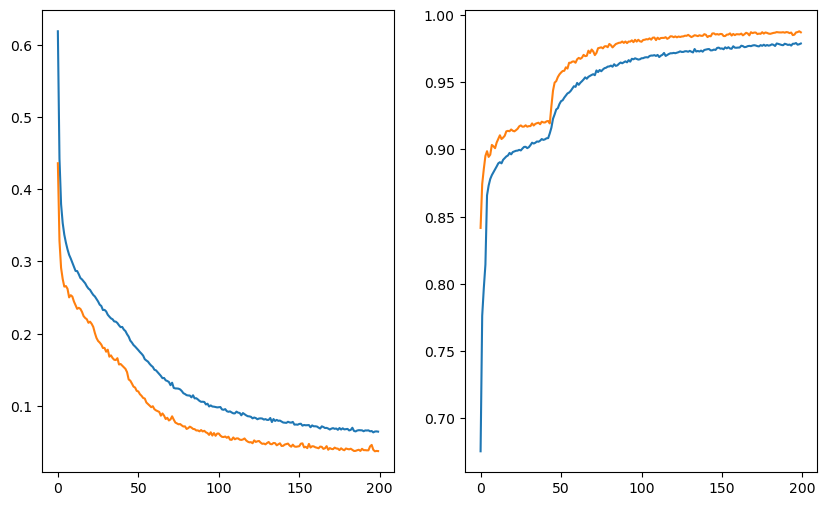

In [13]:
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history["loss"], label="loss")
plt.plot(result.history["val_loss"], label="val_loss")

plt.subplot(1, 2, 2)
plt.plot(result.history["accuracy"], label="accuracy")
plt.plot(result.history["val_accuracy"], label="val_accuracy")

## 결측치를 imputer로 처리하기

In [46]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
service_imputer_mean = imputer.fit_transform(service)
service_imputer_mean = pd.DataFrame(service_imputer_mean, columns=service.columns)
service_imputer_mean.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15.0,1.0,0.0,11.95,25.0,0.140000,0.0,8.4,2.3,0.0,0.0
1,18.0,0.0,0.0,8.22,0.0,0.716039,0.0,0.0,0.0,0.0,1.0
2,23.0,1.0,0.0,8.91,16.0,0.000000,0.0,13.7,0.9,0.0,1.0
3,27.0,0.0,0.0,6.87,21.0,0.716039,1.0,0.0,0.0,0.0,1.0
4,34.0,0.0,0.0,6.39,0.0,0.716039,0.0,0.0,0.0,0.0,1.0


In [47]:
service_imputer_mean.isna().sum()

id                             0
is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
reamining_contract             0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
churn                          0
dtype: int64

In [48]:
X = service_imputer_mean[service_imputer_mean.columns[:-1]]
y = service_imputer_mean["churn"]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [51]:
model = Sequential()
model.add(Flatten(input_shape=(10,)))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(4, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
tf_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=3e-5), metrics=["accuracy"])
model.summary()   

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 10)                0         
                                                                 
 dense_12 (Dense)            (None, 256)               2816      
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dropout_12 (Dropout)        (None, 64)               

In [52]:
result = model.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[tf_stop])

Epoch 1/200
1446/1446 [==============================] - 4s 2ms/step - loss: 0.6280 - accuracy: 0.6093 - val_loss: 0.5008 - val_accuracy: 0.8299
Epoch 2/200
1446/1446 [==============================] - 4s 2ms/step - loss: 0.4933 - accuracy: 0.8149 - val_loss: 0.4119 - val_accuracy: 0.8738
Epoch 3/200
1446/1446 [==============================] - 3s 2ms/step - loss: 0.4393 - accuracy: 0.8536 - val_loss: 0.3855 - val_accuracy: 0.8874
Epoch 4/200
1446/1446 [==============================] - 4s 2ms/step - loss: 0.4142 - accuracy: 0.8674 - val_loss: 0.3668 - val_accuracy: 0.8928
Epoch 5/200
1446/1446 [==============================] - 4s 2ms/step - loss: 0.3989 - accuracy: 0.8743 - val_loss: 0.3561 - val_accuracy: 0.8978
Epoch 6/200
1446/1446 [==============================] - 4s 2ms/step - loss: 0.3851 - accuracy: 0.8786 - val_loss: 0.3514 - val_accuracy: 0.8955
Epoch 7/200
1446/1446 [==============================] - 4s 2ms/step - loss: 0.3754 - accuracy: 0.8814 - val_loss: 0.3402 - val_ac

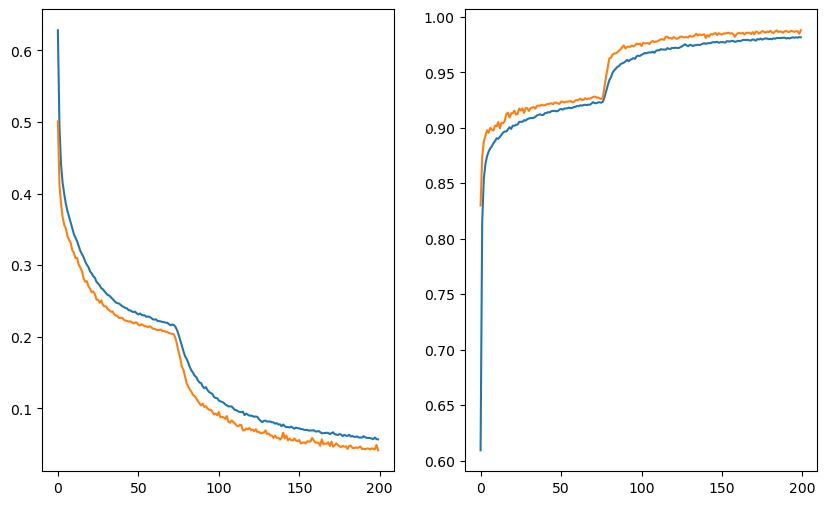

In [53]:
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history["loss"], label="loss")
plt.plot(result.history["val_loss"], label="val_loss")

plt.subplot(1, 2, 2)
plt.plot(result.history["accuracy"], label="accuracy")
plt.plot(result.history["val_accuracy"], label="val_accuracy")

In [57]:
model.save("churn_predict.h5")